In [1]:
#import sys
import numpy as np
from importlib import reload
import h5py
import os
import copy
import gc
import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt, patches
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm 
from matplotlib.ticker import MultipleLocator, FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib as mpl

import astropy.io.fits as fits
import astropy.units as u
from astropy.wcs import WCS
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, ICRS, Galactic

from scipy.interpolate import interpn
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import stats

from reproject import reproject_to_healpix, reproject_from_healpix
from reproject import reproject_interp
import healpy as hp

In [2]:
def FD_moments(data,peakthresh,maxFD,RM_arr,M0=True,M1=True,M2=False,*args,**kwargs):
 
    dFD = abs(RM_arr[1]-RM_arr[0])

    # cut out FD range chosen:
    data_use = data[(abs(RM_arr) <= maxFD),:,:]    
    RM_arr_use = RM_arr[(abs(RM_arr) <= maxFD)]  

    # set any data points below PI threshold to NaN:
    data_use[data_use < peakthresh] = np.nan

    moments = {}
    if M0:
        M0_data = dFD*np.nansum(data_use,axis=0)
        M0_data[M0_data == 0] = np.nan
        moments['M0'] = M0_data
    if M1:
        M1_data = dFD*np.nansum(data_use*RM_arr_use[:,np.newaxis,np.newaxis],axis=0)/M0_data
        moments['M1'] = M1_data
    if M2:
        M2_data = np.sqrt(dFD*np.nansum(data_use*(RM_arr_use[:,np.newaxis,np.newaxis]-M1_data)**2,axis=0)/M0_data)
        moments['M2'] = M2_data
        
    return(moments)

## Read in CHIME data

In [3]:
hdu_chime = fits.open('/srv/data/chime/chime_FD_Oct2023_586_729/FDF_clean_tot.fits')
hdr_chime = hdu_chime[0].header
chime_FD  = hdu_chime[0].data

FD_ax_chime = WCS(hdr_chime).all_pix2world(0,0,range(chime_FD.shape[0]),0)[2]
print(FD_ax_chime[0],FD_ax_chime[-1])
print(chime_FD.shape)

-200.0 200.0
(401, 1440, 2880)


## Read in DRAGONS data

In [4]:
hdu_dragons = fits.open('/srv/data/dragons/Mar2024_500_1000_MHz_cube/FD_cube_DRAGONS_CLEAN_32.fits')
hdr_dragons = hdu_dragons[0].header
dragons_FD  = hdu_dragons[0].data

FD_ax_dragons = WCS(hdr_dragons).all_pix2world(0,0,range(dragons_FD.shape[0]),0)[2]
print(FD_ax_dragons[0],FD_ax_dragons[-1])
print(dragons_FD.shape)

-400.0 400.0
(801, 360, 720)


## Read in GMIMS data

In [5]:
hdu_gmims = fits.open('/srv/data/gmims/gmims-hbn/GMIMS-HBN_v1_gal_car_FD_PI.fits')
hdr_gmims = hdu_gmims[0].header
gmims_FD  = hdu_gmims[0].data

FD_ax_gmims = WCS(hdr_gmims).all_pix2world(0,0,range(gmims_FD.shape[0]),0)[2]
print(FD_ax_gmims[0],FD_ax_gmims[-1])
print(gmims_FD.shape)

-500.0 500.0
(201, 720, 1440)


## Read in Hutschenreuter data

In [6]:
hdu_EG = fits.open('/srv/aordog/faraday2020v2.fits')
hdr_EG = hdu_EG[0].header
RM_EG  = hdu_EG[1].data.faraday_sky_mean

print(RM_EG.shape)

(3145728,)


## Calculate CHIME, DRAGONS, HBN moments:

In [7]:
M1_chime   = FD_moments(chime_FD,   0.08, 100, FD_ax_chime,  M0=True,M1=True,M2=False)['M1']
M1_gmims   = FD_moments(gmims_FD,   0.03,500, FD_ax_gmims,  M0=True,M1=True,M2=False)['M1']
M1_dragons = FD_moments(dragons_FD, 0.5, 100, FD_ax_dragons,M0=True,M1=True,M2=False)['M1']

## CHIME, DRAGONS, HBN to Healpix

In [8]:
hdr2D_chime = hdr_chime.copy()
hdr2D_chime['NAXIS'] = 2
for card in hdr_chime.cards:
    try:
        if card[0][5] == '3':
            del hdr2D_chime[card[0]]
    except:
        pass
#print(repr(hdr2D_chime))

hdr2D_gmims = hdr_gmims.copy()
hdr2D_gmims['NAXIS'] = 2
hdr2D_gmims['WCSAXES'] = 2
for card in hdr_gmims.cards:
    try:
        if card[0][5] == '3':
            del hdr2D_gmims[card[0]]
    except:
        pass
#print(repr(hdr2D_gmims))

hdr2D_dragons = hdr_dragons.copy()
hdr2D_dragons['NAXIS'] = 2
hdr2D_dragons['WCSAXES'] = 2
for card in hdr_dragons.cards:
    try:
        if card[0][5] == '3':
            del hdr2D_dragons[card[0]]
    except:
        pass

M1_hpx_chime,   footprint = reproject_to_healpix((M1_chime,   hdr2D_chime),'galactic', nside=512)
M1_hpx_gmims,   footprint = reproject_to_healpix((M1_gmims,   hdr2D_gmims),'galactic', nside=512)
M1_hpx_dragons, footprint = reproject_to_healpix((M1_dragons, hdr2D_dragons),'galactic', nside=512)

## Hutschenreuter to plate caree (CHIME header)

In [9]:
RM_EG_pc, footprint = reproject_from_healpix((RM_EG,'galactic'),hdr2D_chime, nested=False)


## Mollweide maps of all data sets

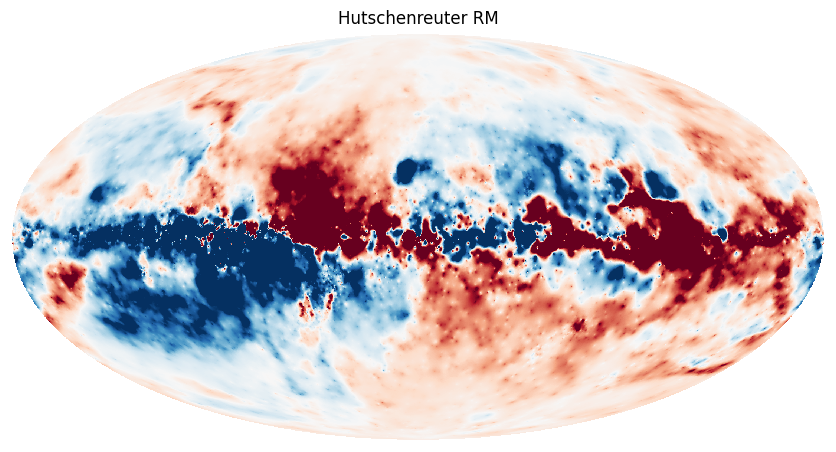

In [10]:
hp.mollview(RM_EG,cmap='RdBu_r',min=-80,max=80,rot=(0,0),
            xsize=3000,cbar=False,title='Hutschenreuter RM')

#plt.savefig('/home/aordog/GMIMS_PLOTS/hutschenreuter.png',dpi=300)

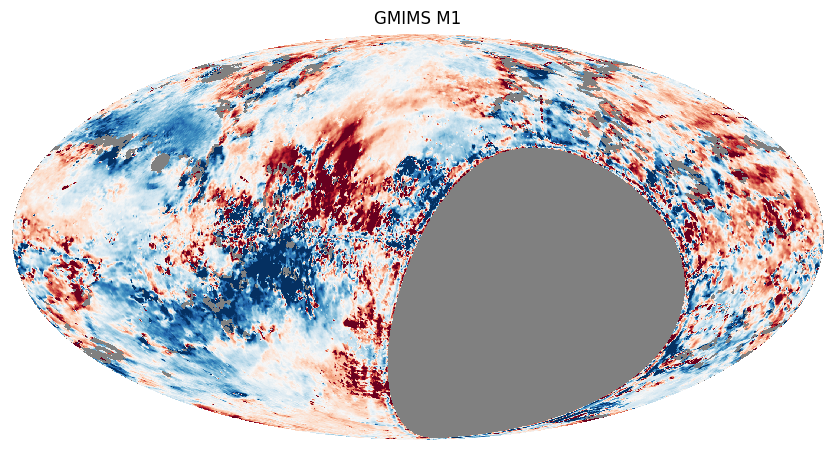

In [11]:
hp.mollview(M1_hpx_gmims,cmap='RdBu_r',min=-40,max=40,rot=(0,0),
            xsize=3000,cbar=False,title='GMIMS M1')

#plt.savefig('/home/aordog/GMIMS_PLOTS/GMIMS_HBN_M1.png',dpi=300)

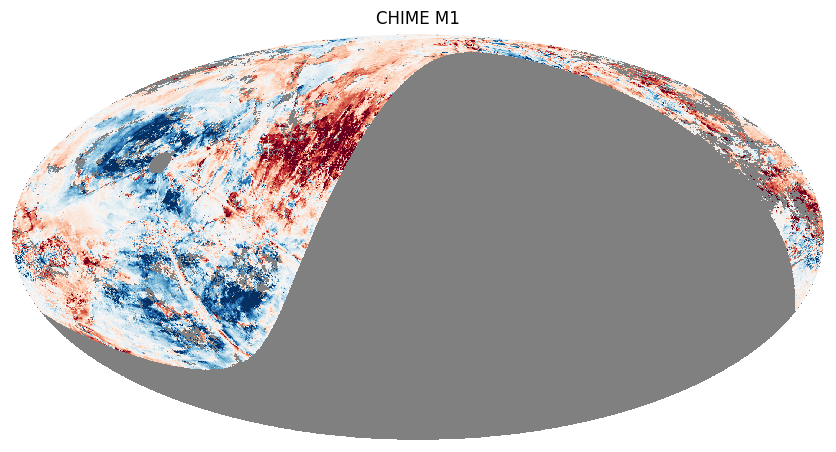

In [12]:
hp.mollview(M1_hpx_chime,cmap='RdBu_r',min=-20,max=20,rot=(0,0),
            xsize=3000,cbar=False,title='CHIME M1')

#plt.savefig('/home/aordog/GMIMS_PLOTS/CHIME_M1.png',dpi=300)

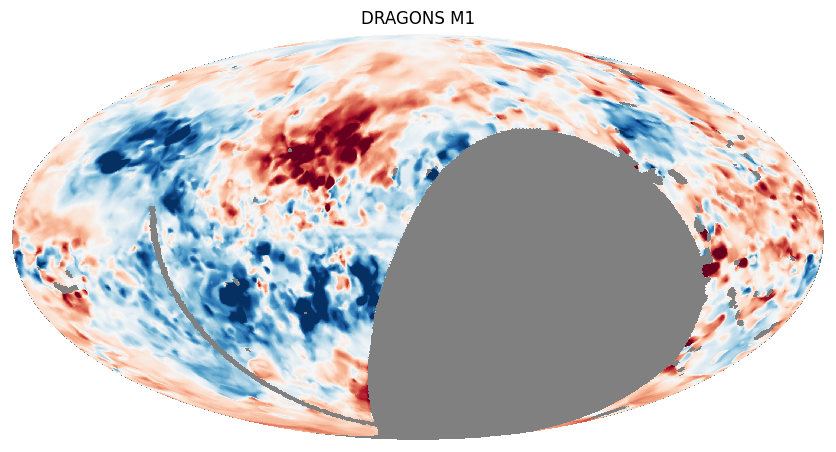

In [13]:
hp.mollview(M1_hpx_dragons,cmap='RdBu_r',min=-20,max=20,rot=(0,0),
            xsize=3000,cbar=False,title='DRAGONS M1')

#plt.savefig('/home/aordog/GMIMS_PLOTS/DRAGONS_M1.png',dpi=300)

## Make longitude and latitude arrays

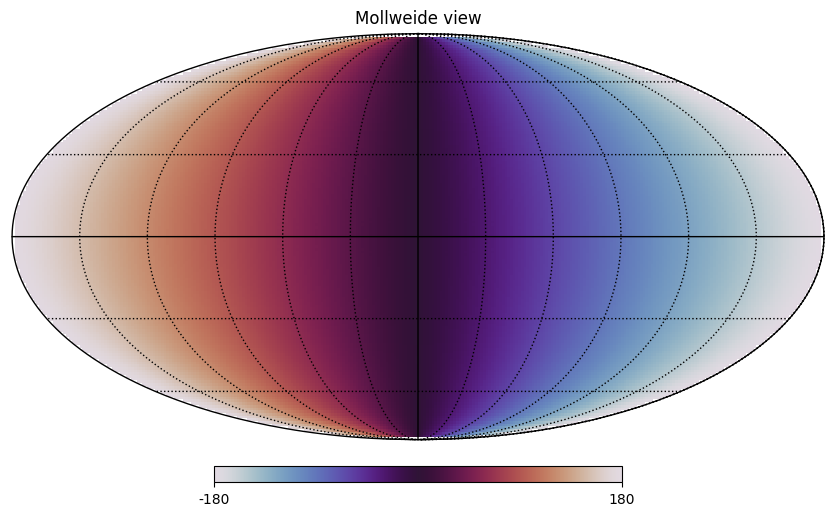

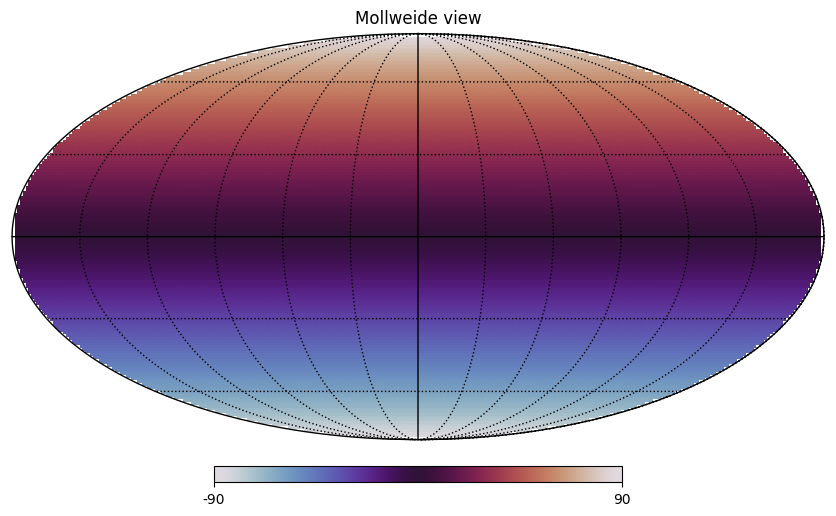

In [10]:
npix = hp.nside2npix(512)

idxs = np.arange(npix)
lon, lat = hp.pix2ang(512, idxs, lonlat=True)
lon[lon>180] = lon[lon>180]-360

hp.mollview(lon,cmap='twilight',min=-180,max=180,
            xsize=300,cbar=True)
hp.visufunc.graticule()

hp.mollview(lat,cmap='twilight',min=-90,max=90,
            xsize=300,cbar=True)
hp.visufunc.graticule()

In [11]:
def calc_medians(data,db=5,dl=10):

    b_bin = np.arange(2.5,90,db)
    l_bin = np.arange(-170,190,dl)

    #print(b_bin)
    #print(l_bin)

    print(data.shape)

    bin = np.empty([len(b_bin),len(l_bin)])
    std = np.empty([len(b_bin),len(l_bin)])
    
    #print(bin.shape)
    
    for i in range(0,len(b_bin)):
        #print('------------------------')
        for j in range(0,len(l_bin)):
            
            w = np.where((lon >= l_bin[j]-dl/2.) & (lon <= l_bin[j]+dl/2.) &
                         (lat >= b_bin[i]-db/2.) & (lat <= b_bin[i]+db/2.))[0]
            #print(lon[w[0]],lon[w[-1]])
            #print(lat[w[0]],lat[w[-1]])
            #print('')
            
            bin[i,j] = np.nanmedian(data[w])
            std[i,j] = np.nanstd(data[w])
            
        #print(b_bin[i],len(w))

    return l_bin, b_bin, bin, std

In [12]:
def func(x, C0, C1, C2, phi1, phi2):
    
    return C0 + C1*np.sin(x+phi1)+C2*np.sin(2*(x+phi2))

def make_label(popt):
        
    C0 = str(round(popt[0],1))
    C1 = str(round(popt[1],1))
    C2 = str(round(popt[2],1))
    phi1 = round(popt[3]*180./np.pi,0)
    phi2 = round(popt[4]*180./np.pi,0)
    
    if phi1>=0:
        if phi2>=0:
            eqn = C0+'+'+r'$\bf{'+C1+r'}$sin($\ell$+'+str(phi1)+'$^{\circ}$)'+'+'+r'$\bf{'+C2+r'}$sin[2($\ell$+'+str(phi2)+'$^{\circ}$)]'
        else:
            eqn = C0+'+'+r'$\bf{'+C1+r'}$sin($\ell$+'+str(phi1)+'$^{\circ}$)'+'+'+r'$\bf{'+C2+r'}$sin[2($\ell$-'+str(abs(phi2))+'$^{\circ}$)]'
    else:
        if phi2>=0:
            eqn = C0+'+'+r'$\bf{'+C1+r'}$sin($\ell$-'+str(abs(phi1))+'$^{\circ}$)'+'+'+r'$\bf{'+C2+r'}$sin[2($\ell$+'+str(phi2)+'$^{\circ}$)]'
        else:
            eqn = C0+'+'+r'$\bf{'+C1+r'}$sin($\ell$-'+str(abs(phi1))+'$^{\circ}$)'+'+'+r'$\bf{'+C2+r'}$sin[2($\ell$-'+str(abs(phi2))+'$^{\circ}$)]'
        
    return(eqn)

In [17]:
db = 5.
dl = 10.

l_bin, b_bin, bin_chime,   std_chime   = calc_medians(M1_hpx_chime,   db=db,dl=dl)
l_bin, b_bin, bin_dragons, std_dragons = calc_medians(M1_hpx_dragons, db=db,dl=dl)
l_bin, b_bin, bin_gmims,   std_gmims   = calc_medians(M1_hpx_gmims,   db=db,dl=dl)
l_bin, b_bin, bin_eg_rm,   std_eg_rm   = calc_medians(RM_EG,          db=db,dl=dl)

(3145728,)


/srv/envs/env_2024-02/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/srv/envs/env_2024-02/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(3145728,)
(3145728,)
(3145728,)


In [18]:
bin_all = {'CHIME M1':    {'bin':bin_chime,  'std':std_chime,  'clr':'C0', 'mkr':"x",'s':200},
           'DRAGONS M1':  {'bin':bin_dragons,'std':std_dragons,'clr':'C1', 'mkr':"+",'s':200},
           'GMIMS HBN M1':{'bin':bin_gmims,  'std':std_gmims,  'clr':'blue','mkr':"o",'s':100},
           'EG RM':       {'bin':bin_eg_rm,  'std':std_eg_rm,  'clr':'red', 'mkr':"*",'s':100}}


In [19]:
def make_lon_plots(data,savefigs=False):

    bounds1 = [-100, 0,   0,  -np.pi, -np.pi/2.]
    bounds2 = [ 100, 100, 100, np.pi,  np.pi/2.]
    lsmooth = np.linspace(-180,180,1001)

    fs = 26

    for k in range(0,len(b_bin)):
    #for k in range(0,1):
        
        print(b_bin[k])

        title = r'Latitude range: '+str(b_bin[k]-db/2)+'$^{\circ}$ to '+str(b_bin[k]+db/2)+'$^{\circ}$'
        fig, axs = plt.subplots(1,2,figsize=(36,8))
        plt.subplots_adjust(wspace=0, hspace=0)

        i = 0 
        for survey in data.keys():
    
            idx_good = np.where(np.isfinite(data[survey]['bin'][k,:]))[0]
    
            popt, pcov = curve_fit(func, 
                                   l_bin[idx_good]*np.pi/180., data[survey]['bin'][k,:][idx_good],
                                   bounds=(bounds1,bounds2))

            label = survey+': '+make_label(popt)

            axs[0].scatter(l_bin,data[survey]['bin'][k,:],marker=data[survey]['mkr'],
                           color=data[survey]['clr'], s=data[survey]['s'])
            axs[1].scatter(l_bin,data[survey]['bin'][k,:],marker=data[survey]['mkr'],
                           color=data[survey]['clr'], s=data[survey]['s'],label=label)
            #axs.errorbar(l_bin,data[survey]['bin'][k,:],yerr=data[survey]['std'][k,:],
            #             fmt=markers[i],color=colors[i],markersize=15)
            axs[0].plot(lsmooth,func(lsmooth*np.pi/180., *popt),color=data[survey]['clr'],linewidth=3)

            i = i+1
            
        axs[0].set_xlim(180,-180)
        axs[0].set_ylim(-40,40)
        axs[0].set_xlabel('Galactic longitude (deg.)',fontsize=fs)
        axs[0].set_ylabel(r'M1 and RM (rad m$^{-2}$)',fontsize=fs)
        axs[0].tick_params(axis="both", labelsize=fs)
        axs[0].set_title(title,fontsize=fs)
        axs[0].grid()
        axs[0].set_xticks([-180,-135,-90,-45,0,45,90,135,180])

        axs[1].legend(fontsize=fs,loc='upper left')
        axs[1].set_xlim(-500,-550)
        axs[1].set_ylim(-500,-550)
        axs[1].axis('off')

        if savefigs:
            plt.savefig('/home/aordog/GMIMS_PLOTS/sine2l_plot_May2024_'+str(b_bin[k])+'.png')
    
    return

In [ ]:
make_lon_plots(bin_all,savefigs=True)

In [ ]:
def make_lon_plots_maps(data,savefigs=False):

    bounds1 = [-100, 0,   0,  -np.pi, -np.pi/2.]
    bounds2 = [ 100, 100, 100, np.pi,  np.pi/2.]
    lsmooth = np.linspace(-180,180,1001)

    fs = 18

    hdr2D = [hdr2D_chime,hdr2D_dragons,hdr2D_gmims]
    FD    = [FD_ax_chime,FD_ax_dragons,FD_ax_gmims]
    maps  = [chime_FD   ,dragons_FD   ,gmims_FD]
    labels= ['CHIME','DRAGONS','GMIMS HBN','EG RMs']
    colors= ['C0','C1','blue']
    wcs   = [WCS(hdr2D_chime),WCS(hdr2D_dragons),WCS(hdr2D_gmims),WCS(hdr2D_chime)]

    for k in range(0,len(b_bin)):
    #for k in range(0,1):
        
        print(b_bin[k])

        title = r'Latitude range: '+str(b_bin[k]-db/2)+'$^{\circ}$ to '+str(b_bin[k]+db/2)+'$^{\circ}$'

        fig = plt.figure(figsize=(24, 13))
        gs = gridspec.GridSpec(4, 6, height_ratios=[1,1,1,1], hspace=0.02, wspace=0.05)
        
        ax1 = plt.subplot(gs[0:3,0:4])
        ax2 = plt.subplot(gs[3,0:4])
        ax3 = plt.subplot(gs[0,4:6], projection=wcs[0].celestial)
        ax4 = plt.subplot(gs[1,4:6], projection=wcs[1].celestial)
        ax5 = plt.subplot(gs[2,4:6], projection=wcs[2].celestial)
        ax6 = plt.subplot(gs[3,4:6], projection=wcs[3].celestial)

        im2 = ax3.imshow(M1_chime,origin='lower',cmap='RdBu_r',vmin=-20,vmax=20)
        im3 = ax4.imshow(M1_dragons,origin='lower',cmap='RdBu_r',vmin=-20,vmax=20)
        im4 = ax5.imshow(M1_gmims,origin='lower',cmap='RdBu_r',vmin=-40,vmax=40)
        im5 = ax6.imshow(RM_EG_pc,origin='lower',cmap='RdBu_r',vmin=-80,vmax=80)

        ims = [im2,im3,im4,im5]
        axs = [ax3,ax4,ax5,ax6]

        for ii in range(0,4):
            axs[ii].coords[0].set_ticks_visible(False)
            axs[ii].coords[1].set_ticks_visible(False)
            axs[ii].coords[0].set_ticklabel_visible(False)
            axs[ii].coords[1].set_ticklabel_visible(False)
            cbar = fig.colorbar(ims[ii], ax=axs[ii], shrink=0.9, pad=0.0)
            cbar.set_label(r'FD (rad m$^{-2}$)',fontsize=fs)
            cbar.ax.tick_params(labelsize=fs) 
            c = SkyCoord(180, 0, frame=Galactic, unit="deg")
            pixels = wcs[ii].world_to_pixel(c)
            i = int(np.round(pixels[0],0))
            j = int(np.round(pixels[1],0))
            axs[ii].text(i,j,labels[ii],fontsize=fs+2,rotation=90,va='center',ha='right')

            c1 = SkyCoord(0, b_bin[k]-db/2, frame=Galactic, unit="deg")
            c2 = SkyCoord(0, b_bin[k]+db/2, frame=Galactic, unit="deg")
            #pixels = wcs[ii].world_to_pixel(c)
            axs[ii].axhline(y=int(np.round(wcs[ii].world_to_pixel(c1)[1],0)),color='k')
            axs[ii].axhline(y=int(np.round(wcs[ii].world_to_pixel(c2)[1],0)),color='k')

        i = 0 
        for survey in data.keys():
    
            idx_good = np.where(np.isfinite(data[survey]['bin'][k,:]))[0]
    
            popt, pcov = curve_fit(func, 
                                   l_bin[idx_good]*np.pi/180., data[survey]['bin'][k,:][idx_good],
                                   bounds=(bounds1,bounds2))

            label = survey+': '+make_label(popt)

            ax1.scatter(l_bin,data[survey]['bin'][k,:],marker=data[survey]['mkr'],
                           color=data[survey]['clr'], s=data[survey]['s'])
            ax2.scatter(l_bin,data[survey]['bin'][k,:],marker=data[survey]['mkr'],
                           color=data[survey]['clr'], s=data[survey]['s'],label=label)
            #axs.errorbar(l_bin,data[survey]['bin'][k,:],yerr=data[survey]['std'][k,:],
            #             fmt=markers[i],color=colors[i],markersize=15)
            ax1.plot(lsmooth,func(lsmooth*np.pi/180., *popt),color=data[survey]['clr'],linewidth=3)

            i = i+1
            
        ax1.set_xlim(180,-180)
        ax1.set_ylim(-40,40)
        ax1.set_xlabel('Galactic longitude (degrees)',fontsize=fs)
        ax1.set_ylabel(r'M1 and RM (rad m$^{-2}$)',fontsize=fs)
        ax1.tick_params(axis="both", labelsize=fs)
        ax1.set_title(title,fontsize=fs+6)
        ax1.grid()
        ax1.set_xticks([-180,-135,-90,-45,0,45,90,135,180])

        ax2.legend(fontsize=fs,loc='lower left')
        ax2.set_xlim(-500,-550)
        ax2.set_ylim(-500,-550)
        ax2.axis('off')

        if savefigs:
            plt.savefig('/home/aordog/GMIMS_PLOTS/sine2l_plot_and_maps_May2024_'+str(b_bin[k])+'.png')
    
    return

In [ ]:
make_lon_plots_maps(bin_all,savefigs=True)

In [26]:
def make_one_spectrum_new(lplot,bplot,lims=[-300,300]):

    hdr2D = [hdr2D_chime,hdr2D_dragons,hdr2D_gmims]
    FD    = [FD_ax_chime,FD_ax_dragons,FD_ax_gmims]
    data  = [chime_FD   ,dragons_FD   ,gmims_FD]
    labels= ['CHIME','DRAGONS','GMIMS HBN']
    colors= ['C0','C1','blue']
    
    fig, axs = plt.subplots(1,1,figsize=(16,5))
    fs = 18
    
    for k in range(0,3):
        c = SkyCoord(lplot, bplot, frame=Galactic, unit="deg")
        pixels = WCS(hdr2D[k]).world_to_pixel(c)
        i = int(np.round(pixels[0],0))
        j = int(np.round(pixels[1],0))
    
        axs.plot(FD[k],data[k][:,j,i]/np.nanmax(data[k][:,j,i]),label=labels[k],color=colors[k],linewidth=2)

    c = SkyCoord(lplot, bplot, frame=Galactic, unit="deg")
    pixels = WCS(hdr2D_chime).world_to_pixel(c)
    i = int(np.round(pixels[0],0))
    j = int(np.round(pixels[1],0))
    axs.axvline(x=RM_EG_pc[j,i],color='red',label='EG RM',linewidth=2)
    
    axs.legend(fontsize=fs)
    axs.set_title(r'$\ell$='+str(round(c.l.deg,1))+'$^{\circ}$, $b$='+str(round(c.b.deg,1))+'$^{\circ}$',fontsize=fs+2)
    axs.grid(axis="x")
    axs.set_ylim(0,1.1)
    axs.set_xlim(lims)
    axs.tick_params(axis="both", labelsize=fs)
    axs.set_xlabel(r'Faraday Depth (rad m$^{-2}$)',fontsize=fs)
    axs.set_ylabel(r'Peak-normalized PI',fontsize=fs)

    return

In [14]:
def make_one_spectrum_maps(lplot,bplot,lims=[-300,300]):

    hdr2D = [hdr2D_chime,hdr2D_dragons,hdr2D_gmims]
    FD    = [FD_ax_chime,FD_ax_dragons,FD_ax_gmims]
    data  = [chime_FD   ,dragons_FD   ,gmims_FD]
    labels= ['CHIME','DRAGONS','GMIMS HBN']
    colors= ['C0','C1','blue']
    wcs   = [WCS(hdr2D_chime),WCS(hdr2D_dragons),WCS(hdr2D_gmims),WCS(hdr2D_chime)]
    
    fig = plt.figure(figsize=(16,14))
    fs = 12
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    crange = SkyCoord([lplot+15,lplot-15], [bplot-8,bplot+8], frame=Galactic, unit=(u.deg, u.deg))

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(323, projection=wcs[0].celestial)
    ax3 = fig.add_subplot(324, projection=wcs[1].celestial)
    ax4 = fig.add_subplot(325, projection=wcs[2].celestial)
    ax5 = fig.add_subplot(326, projection=wcs[3].celestial)

    im2 = ax2.imshow(M1_chime,origin='lower',cmap='RdBu_r',vmin=-20,vmax=20)
    im3 = ax3.imshow(M1_dragons,origin='lower',cmap='RdBu_r',vmin=-20,vmax=20)
    im4 = ax4.imshow(M1_gmims,origin='lower',cmap='RdBu_r',vmin=-40,vmax=40)
    im5 = ax5.imshow(RM_EG_pc,origin='lower',cmap='RdBu_r',vmin=-40,vmax=40)
 
    axs = [ax2,ax3,ax4,ax5]
    ims = [im2,im3,im4,im5]
    
    for k in range(0,len(axs)):
        axs[k].set_ylim(wcs[k].world_to_pixel(crange)[1])
        axs[k].set_xlim(wcs[k].world_to_pixel(crange)[0])
        cbar = fig.colorbar(ims[k], ax=axs[k], shrink=0.8, pad=0.01)
        axs[k].set_xlabel(' ')
        axs[k].set_ylabel('lat',fontsize=fs)
        axs[k].set_xlabel('lon',fontsize=fs)
        if k < 3:
            c = SkyCoord(lplot, bplot, frame=Galactic, unit="deg")
            pixels = WCS(hdr2D[k]).world_to_pixel(c)
            i = int(np.round(pixels[0],0))
            j = int(np.round(pixels[1],0))
            axs[k].scatter(i,j,color='k',s=100)
            ax1.plot(FD[k],data[k][:,j,i]/np.nanmax(data[k][:,j,i]),label=labels[k],color=colors[k],linewidth=2)

    c = SkyCoord(lplot, bplot, frame=Galactic, unit="deg")
    pixels = WCS(hdr2D_chime).world_to_pixel(c)
    i = int(np.round(pixels[0],0))
    j = int(np.round(pixels[1],0))
    ax1.axvline(x=RM_EG_pc[j,i],color='red',label='EG RM',linewidth=2)
    axs[3].scatter(i,j,color='k',s=100)
    
    ax1.legend(fontsize=fs)
    ax1.set_title(r'$\ell$='+str(round(c.l.deg,1))+'$^{\circ}$, $b$='+str(round(c.b.deg,1))+'$^{\circ}$',fontsize=fs+2)
    ax1.grid(axis="x")
    ax1.set_ylim(0,1.1)
    ax1.set_xlim(lims)
    ax1.tick_params(axis="both", labelsize=fs)
    ax1.set_xlabel(r'Faraday Depth (rad m$^{-2}$)',fontsize=fs)


    return

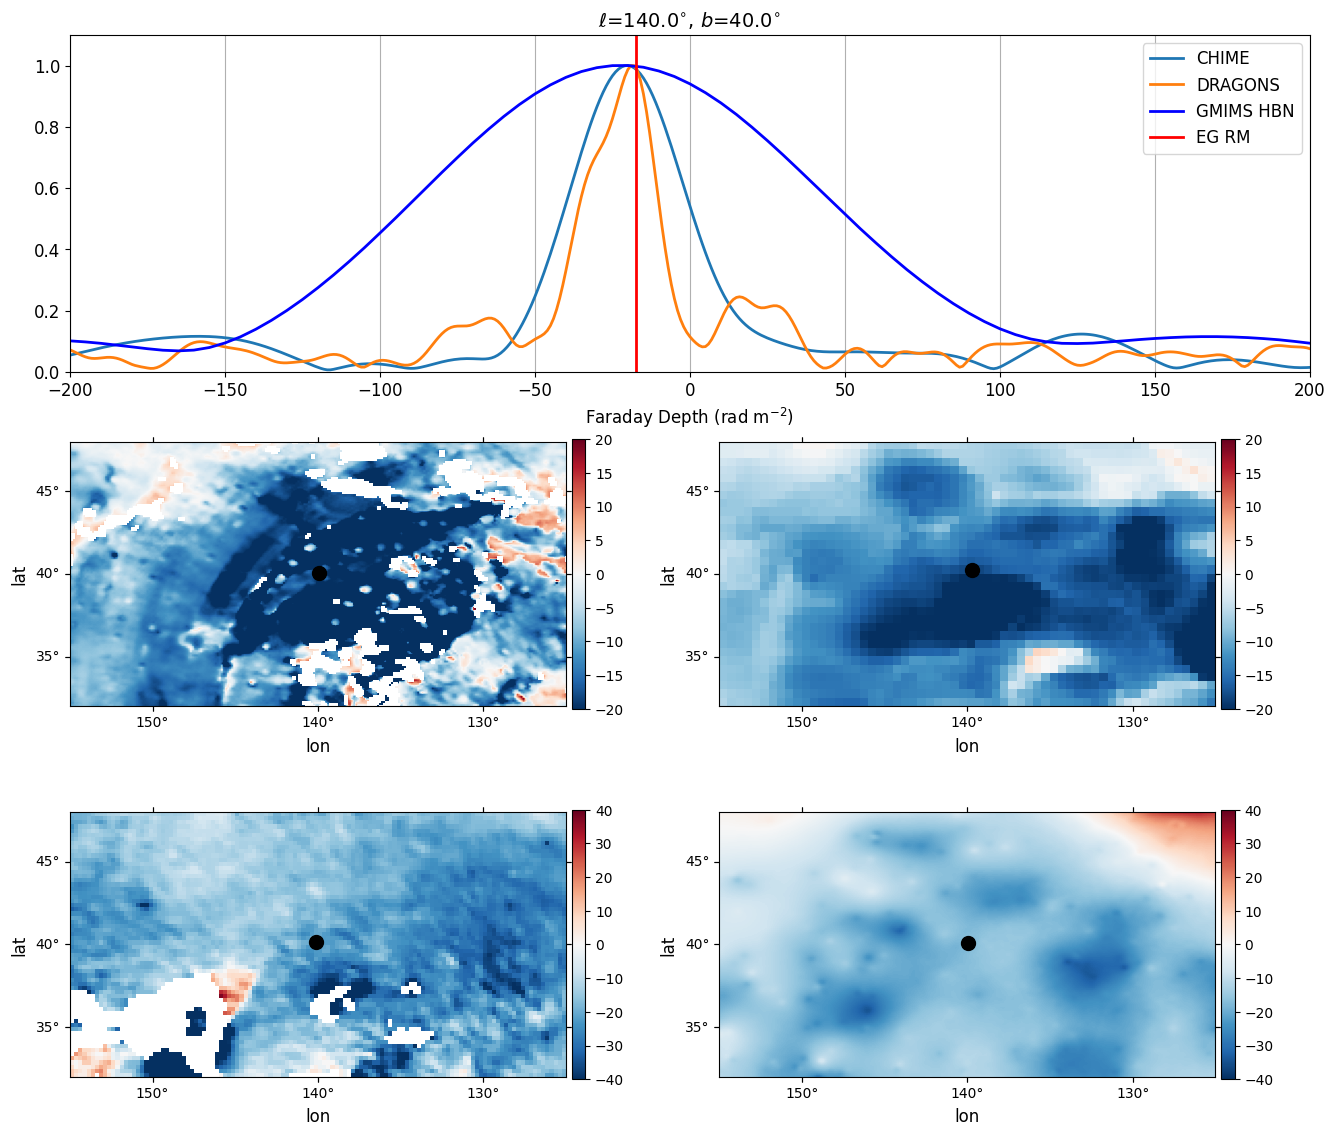

In [41]:
make_one_spectrum_maps(140,40,lims=[-200,200])

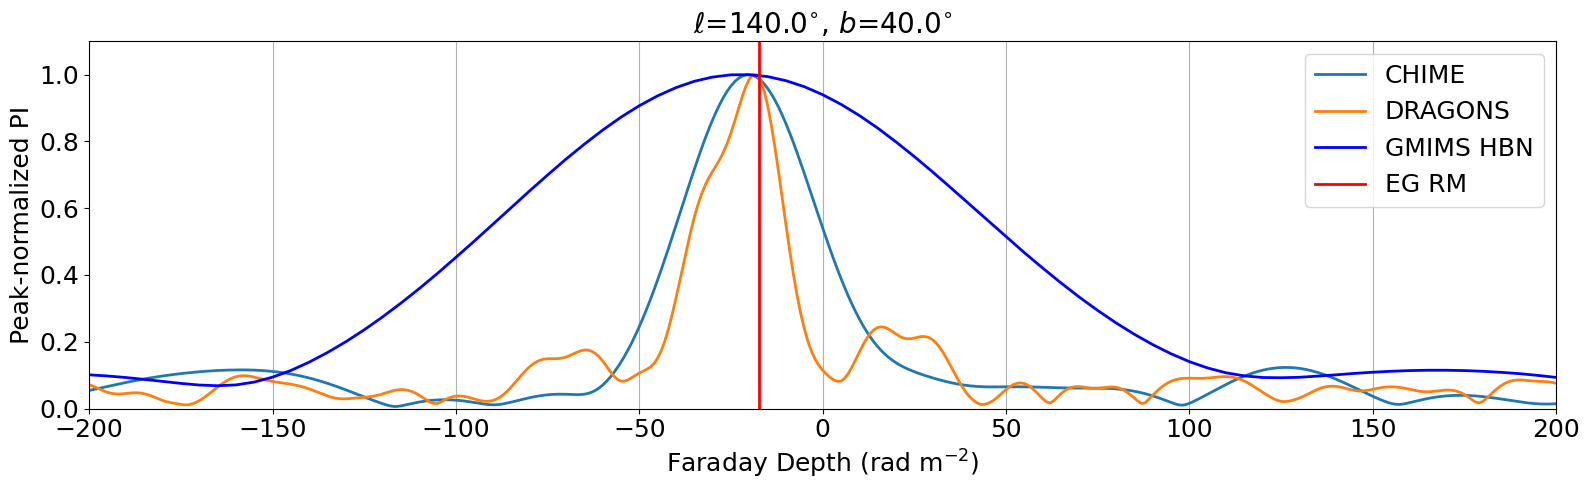

In [42]:
make_one_spectrum_new(140,40,lims=[-200,200])
plt.tight_layout()
plt.savefig('/home/aordog/GMIMS_PLOTS/spectrum_140_40.png')

In [ ]:
c = SkyCoord(137, 7, frame=Galactic, unit="deg")

print(c.l.deg,c.b.deg)

In [ ]:
del M1_chime
del M1_dragons
del M1_gmims

gc.collect()

In [ ]:
chime_FD[chime_FD<=0] = np.nan
dragons_FD[dragons_FD<=0] = np.nan
gmims_FD[gmims_FD<=0] = np.nan

In [ ]:
med_spectrum_dragons = np.nanmedian(dragons_FD,axis=(1,2))
med_spectrum_chime = np.nanmedian(chime_FD,axis=(1,2))
med_spectrum_gmims = np.nanmedian(gmims_FD,axis=(1,2))

In [ ]:
std_spectrum_dragons = np.nanstd(dragons_FD,axis=(1,2))
std_spectrum_chime = np.nanstd(chime_FD,axis=(1,2))
std_spectrum_gmims = np.nanstd(gmims_FD,axis=(1,2))

In [ ]:
print(med_spectrum_dragons.shape)
print(med_spectrum_chime.shape)
print(med_spectrum_gmims.shape)

In [ ]:
plt.plot(FD_ax_chime,med_spectrum_chime)
plt.plot(FD_ax_chime,med_spectrum_chime+std_spectrum_chime)
plt.ylim(0,1.5)
plt.xlim(-200,200)
plt.grid()

In [ ]:
plt.plot(FD_ax_dragons,med_spectrum_dragons)
plt.plot(FD_ax_dragons,med_spectrum_dragons+std_spectrum_dragons)
plt.ylim(0,5.5)
plt.xlim(-200,200)
plt.grid()

In [ ]:
plt.plot(FD_ax_gmims,med_spectrum_gmims)
plt.plot(FD_ax_gmims,med_spectrum_gmims+std_spectrum_gmims)
#plt.ylim(0,2.5)
plt.xlim(-400,400)
plt.grid()